In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("creditcard.csv")

X = df.drop('Class',axis=1)
y = df['Class']
# df.head()

In [3]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X_scaled, y)

In [5]:
#Anomaly Detection using Isolation Forest

from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination='auto',random_state=42)
y_pred_if = iso_forest.fit_predict(X_new)

#convert predections to binary(1:Normal , -1: Anomaly)
df['Anomaly_if'] = y_pred_if

anomalies_if = df[df['Anomaly_if']==-1]
anomalies_if.head()
# anomalies_if.shape

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Anomaly_if
18,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,...,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0,-1
51,36.0,-1.004929,-0.985978,-0.038039,3.710061,-6.631951,5.122103,4.371691,-2.006868,-0.278736,...,-0.381671,0.969719,0.019445,0.570923,0.333278,0.857373,-0.075538,1402.95,0,-1
82,52.0,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,1.46,0,-1
83,53.0,-1.198968,-1.474100,1.840326,-4.515824,0.327567,-0.174469,0.959726,-1.026456,1.700435,...,0.334614,-0.364541,-0.310186,-0.302599,-1.243924,-1.123457,-0.734351,89.17,0,-1
85,55.0,-4.575093,-4.429184,3.402585,0.903915,3.002224,-0.491078,-2.705393,0.666451,1.922216,...,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,0,-1


In [6]:
#Imbalanced Classification with SMOTE and Random Forest

df_labeld = pd.concat([df,anomalies_if])
df_labeld.shape

(298065, 32)

In [7]:
#Re-separate features and targets for the labeled dataset
X_labeld = df_labeld.drop(['Class','Anomaly_if'],axis=1)
y_labeld = df_labeld['Class']

In [8]:
#Apply SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = 0.5,random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_labeld,y_labeld)

In [9]:
#split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)

In [10]:
#Train a RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [11]:
#Predict on the test set
y_pred = rf.predict(X_test)

In [12]:
# Evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, y_pred))

[[59479     3]
 [   12 29648]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59482
           1       1.00      1.00      1.00     29660

    accuracy                           1.00     89142
   macro avg       1.00      1.00      1.00     89142
weighted avg       1.00      1.00      1.00     89142

AUC-ROC: 0.9997724896370446


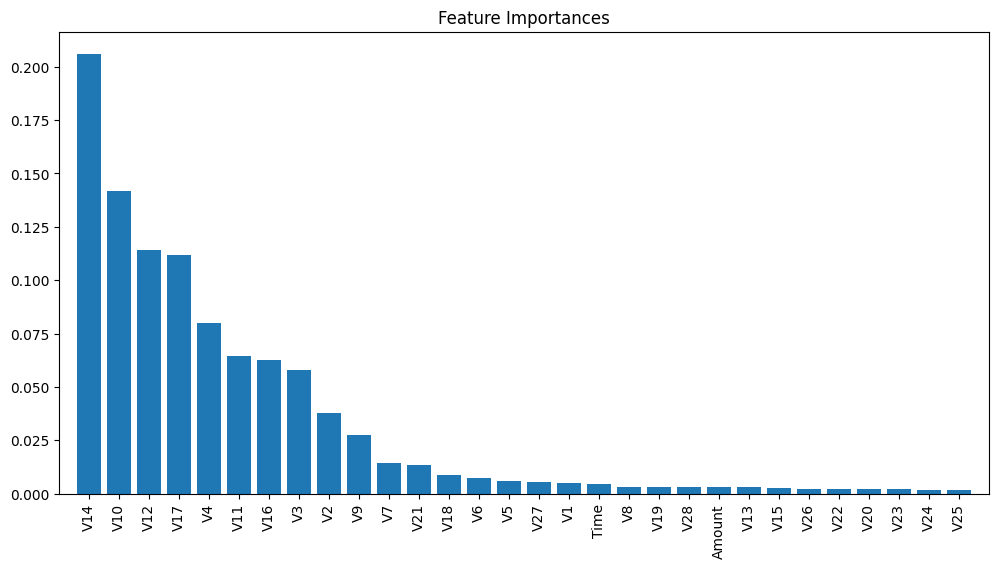

In [13]:
# Plot feature importance (optional)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()